# Designing models for CRC cell lines

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
import theano

In [3]:
from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.modeling import pymc3_analysis as pmanal
from src.modeling import pymc3_sampling_api as sampling
from src.models import crc_models
from src.plot.color_pal import SeabornColor

In [4]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_classic() + gg.theme(strip_background=gg.element_blank()))
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 914
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")

## Data

In [107]:
data = achelp.read_achilles_data(
    Path("..", "..", "modeling_data", "depmap_CRC_data_subsample.csv"),
    set_categorical_cols=False,
)
# data = achelp.subsample_achilles_data(data, n_genes=20, n_cell_lines=10)
data = achelp.set_achilles_categorical_columns(data)
data.head()

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,any_deleterious,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr,log2_cn,z_log2_cn,is_mutated
0,CCACCCACAGACGCTCAGCA,ls513-311cas9_repa_p6_batch2,0.029491,2,True,ACH-000007,Primary,colorectal,colorectal_adenocarcinoma,G12D,...,False,NaN,NaN,NaN,NaN,False,1.480265,1.861144,1.386218,0
1,CCACCCACAGACGCTCAGCA,ls513-311cas9_repb_p6_batch2,0.426017,2,True,ACH-000007,Primary,colorectal,colorectal_adenocarcinoma,G12D,...,False,NaN,NaN,NaN,NaN,False,1.480265,1.861144,1.386218,0
2,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep a p5_batch3,0.008626,3,True,ACH-000009,Primary,colorectal,colorectal_adenocarcinoma,WT,...,False,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.234394,0
3,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep b p5_batch3,0.280821,3,True,ACH-000009,Primary,colorectal,colorectal_adenocarcinoma,WT,...,False,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.234394,0
4,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep c p5_batch3,0.239815,3,True,ACH-000009,Primary,colorectal,colorectal_adenocarcinoma,WT,...,False,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.234394,0


In [108]:
data.shape

(34760, 30)

## Model Experimentation

### Model design

In [109]:
lfc_data = data.lfc.values
total_size = len(data.lfc.values)

indices = achelp.common_indices(data)

sgrna_idx = indices["sgrna_idx"]
sgrna_to_gene_idx = indices["sgrna_to_gene_idx"]
gene_idx = indices["gene_idx"]
cellline_idx = indices["cellline_idx"]
batch_idx = indices["batch_idx"]

n_sgrnas = dphelp.nunique(sgrna_idx)
n_genes = dphelp.nunique(gene_idx)
n_celllines = dphelp.nunique(cellline_idx)
n_batches = dphelp.nunique(batch_idx)

sgrna_idx_shared = theano.shared(sgrna_idx)
sgrna_to_gene_idx_shared = theano.shared(sgrna_to_gene_idx)
gene_idx_shared = theano.shared(gene_idx)
cellline_idx_shared = theano.shared(cellline_idx)
batch_idx_shared = theano.shared(batch_idx)
lfc_shared = theano.shared(lfc_data)

with pm.Model() as model:

    # Hyper-priors
    σ_a = pm.HalfNormal("σ_a", np.array([0.1, 0.2]), shape=2)
    a = pm.Exponential("a", σ_a, shape=(n_genes, 2))

    μ_h = pm.Normal("μ_h", np.mean(lfc_data), 1)
    σ_h = pm.HalfNormal("σ_h", 1)

    μ_d = pm.Normal("μ_d", 0, 0.2)
    σ_d = pm.HalfNormal("σ_d", 0.5)

    μ_η = pm.Normal("μ_η", 0, 0.2)
    σ_η = pm.HalfNormal("σ_η", 0.5)

    # Main parameter priors
    q = pm.Beta(
        "q",
        alpha=a[sgrna_to_gene_idx_shared, 0],
        beta=a[sgrna_to_gene_idx_shared, 1],
        shape=n_sgrnas,
    )
    h = pm.Normal("h", μ_h, σ_h, shape=n_genes)
    d = pm.Normal("d", μ_d, σ_d, shape=(n_genes, n_celllines))
    η = pm.Normal("η", μ_η, σ_η, shape=n_batches)

    μ = pm.Deterministic(
        "μ",
        q[sgrna_idx_shared]
        * (h[gene_idx_shared] + d[gene_idx_shared, cellline_idx_shared])
        + η[batch_idx_shared],
    )
    σ = pm.HalfNormal("σ", 2)

    # Likelihood
    lfc = pm.Normal("lfc", μ, σ, observed=lfc_shared, total_size=total_size)

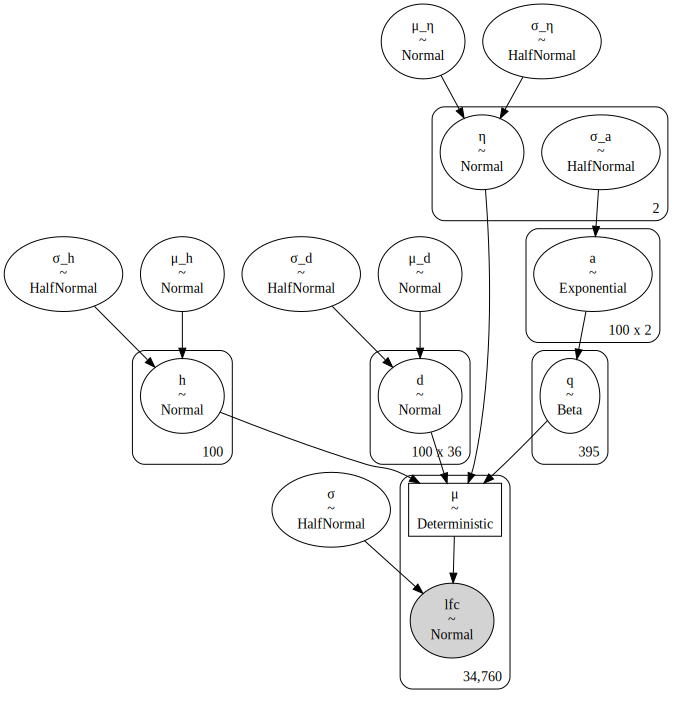

In [110]:
pm.model_to_graphviz(model)

In [111]:
with model:
    prior_pred = pm.sample_prior_predictive(samples=1000, random_seed=RANDOM_SEED)

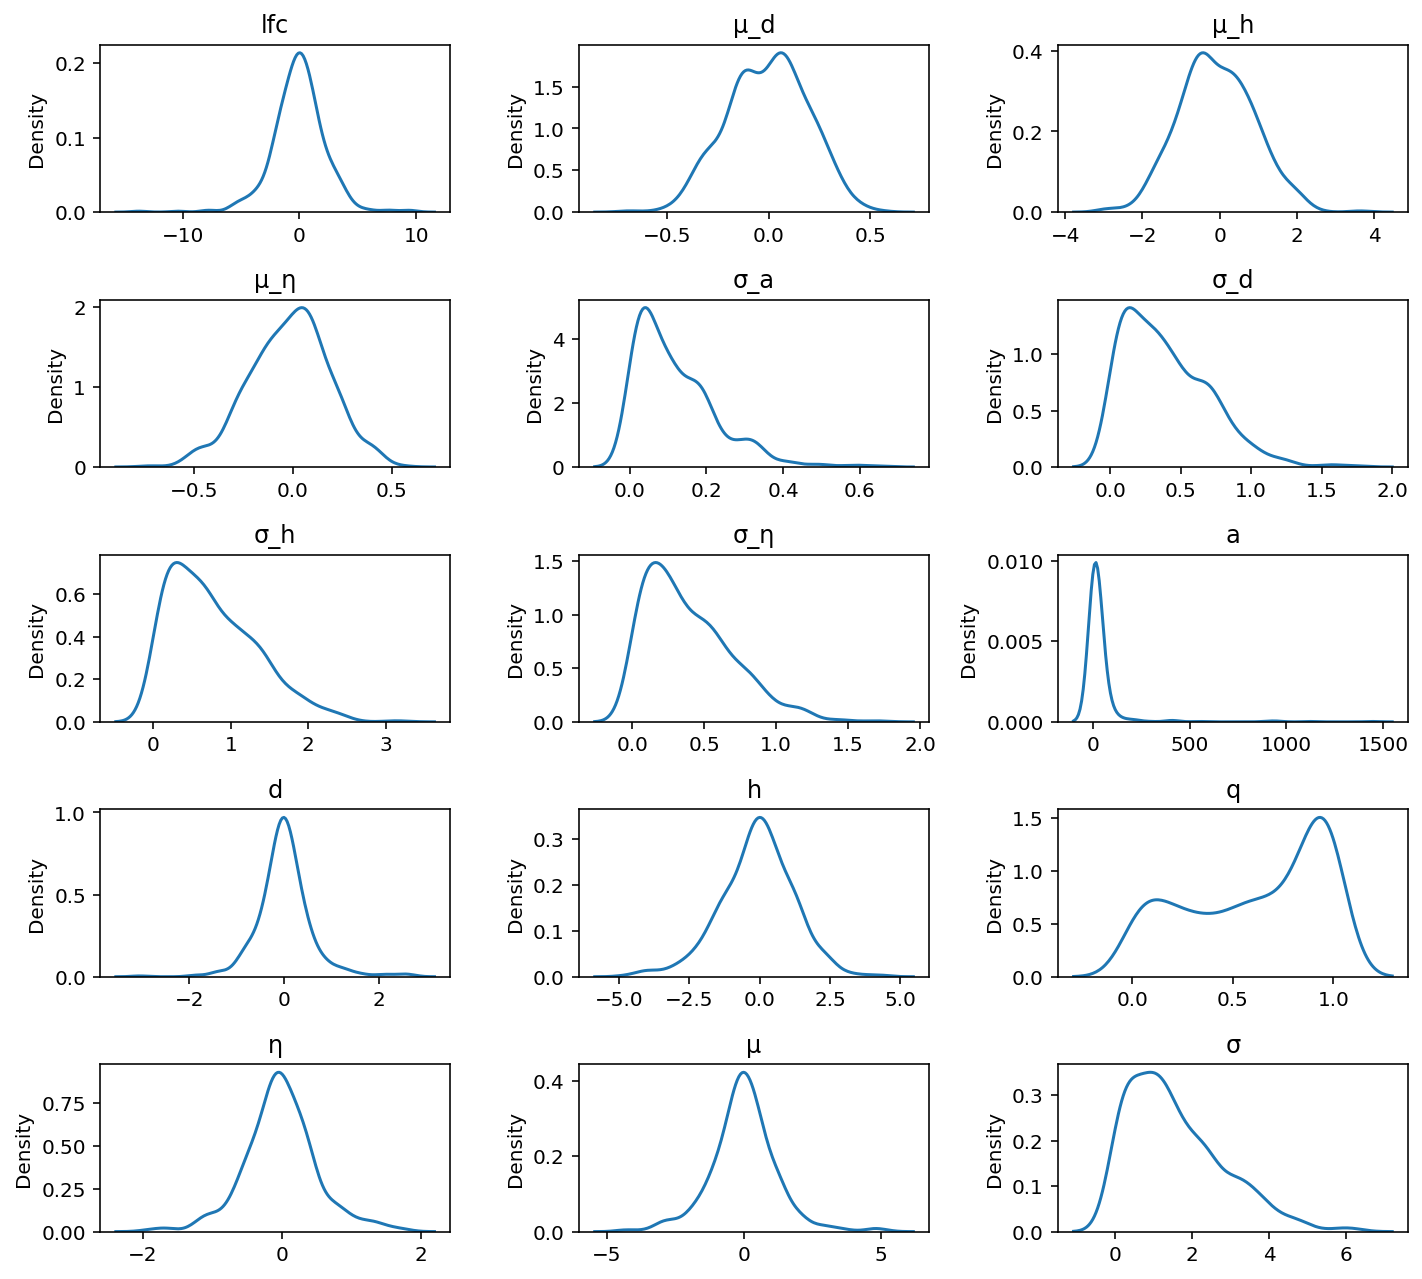

In [112]:
pmanal.plot_all_priors(prior_pred, subplots=(5, 3), figsize=(10, 9), samples=500);

## ADVI

In [113]:
batch_size = 500

sgnra_idx_batch = pm.Minibatch(sgrna_idx, batch_size=batch_size)
gene_idx_batch = pm.Minibatch(gene_idx, batch_size=batch_size)
cellline_idx_batch = pm.Minibatch(cellline_idx, batch_size=batch_size)
batch_idx_batch = pm.Minibatch(batch_idx, batch_size=batch_size)
lfc_data_batch = pm.Minibatch(data.lfc.values, batch_size=batch_size)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [114]:
meanfield = sampling.pymc3_advi_approximation_procedure(
    model=model,
    method="advi",
    callbacks=[
        pm.callbacks.CheckParametersConvergence(tolerance=0.01, diff="absolute")
    ],
    fit_kwargs={
        "more_replacements": {
            sgrna_idx_shared: sgnra_idx_batch,
            gene_idx_shared: gene_idx_batch,
            cellline_idx_shared: cellline_idx_batch,
            batch_idx_shared: batch_idx_batch,
            lfc_shared: lfc_data_batch,
        }
    },
)

Sampling from prior distributions.
Running ADVI approximation.


Convergence achieved at 38900
Interrupted at 38,899 [38%]: Average Loss = 442.85


Sampling from posterior.
Posterior predicitons.


In [115]:
az_model = sampling.samples_to_arviz(model, meanfield)

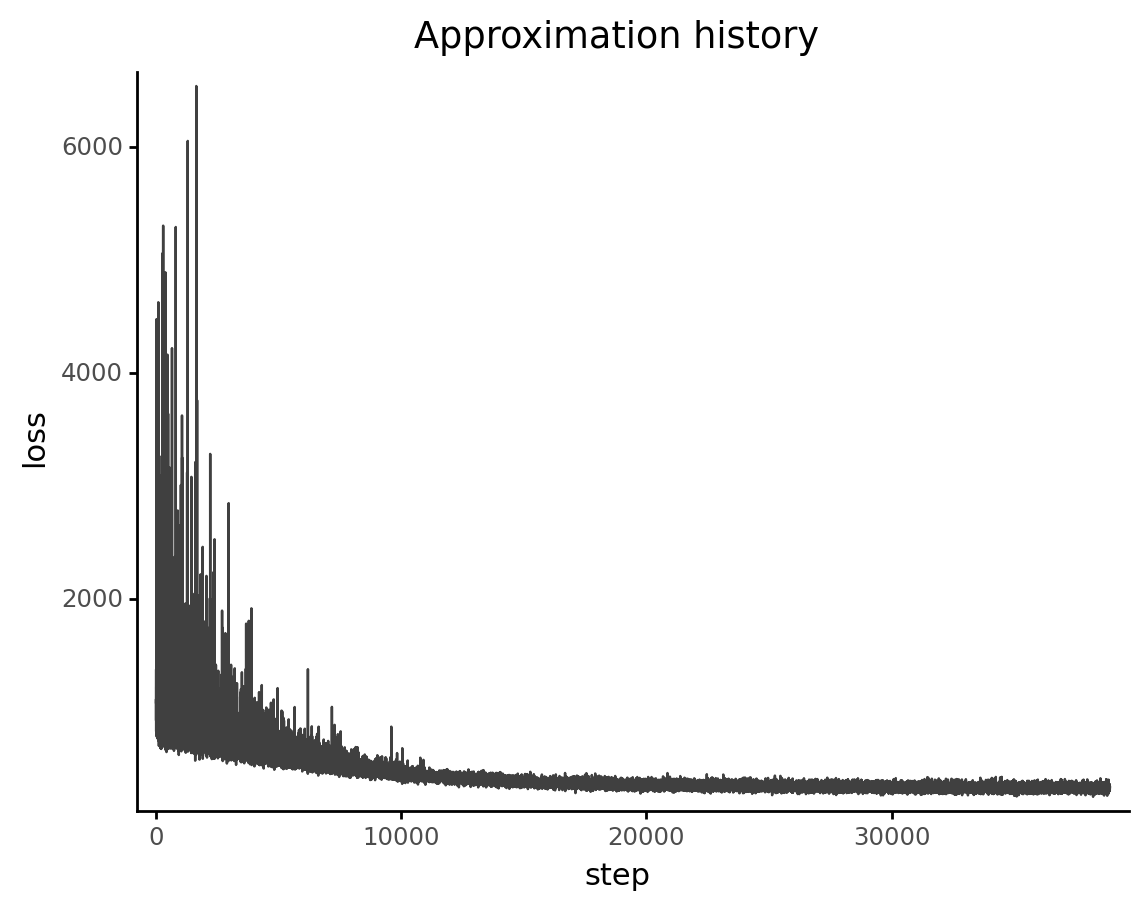

<ggplot: (363979581)>

In [116]:
pmanal.plot_vi_hist(meanfield["approximation"])

## PPC

<AxesSubplot:xlabel='lfc'>

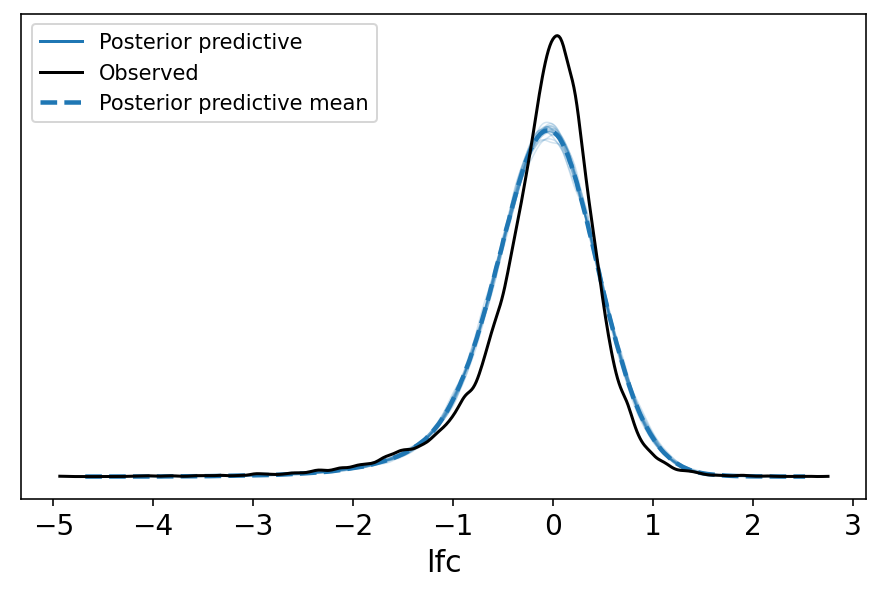

In [145]:
az.plot_ppc(az_model, kind="kde", num_pp_samples=20, random_seed=RANDOM_SEED)

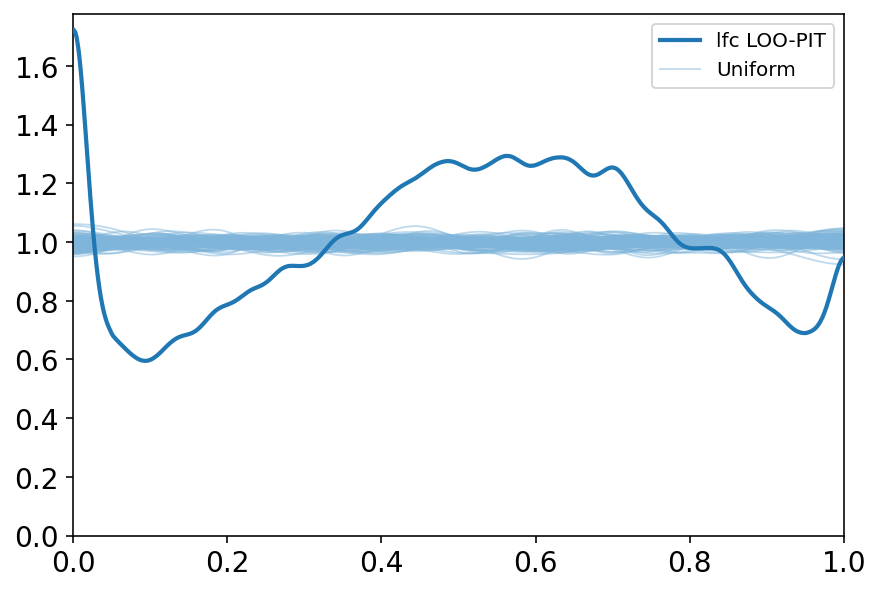

In [146]:
az.plot_loo_pit(az_model, y="lfc");

In [147]:
ppc_df = pmanal.summarize_posterior_predictions(
    meanfield["posterior_predictive"]["lfc"],
    merge_with=data[["hugo_symbol", "sgrna", "depmap_id", "lfc", "gene_cn"]],
    calc_error=True,
)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


In [148]:
model_loo = az.loo(az_model, pointwise=True)
print(model_loo)

Computed from 1000 by 34760 log-likelihood matrix

         Estimate       SE
elpd_loo -24190.28   235.84
p_loo     4756.88        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     30312   87.2%
 (0.5, 0.7]   (ok)        3414    9.8%
   (0.7, 1]   (bad)        795    2.3%
   (1, Inf)   (very bad)   239    0.7%



/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


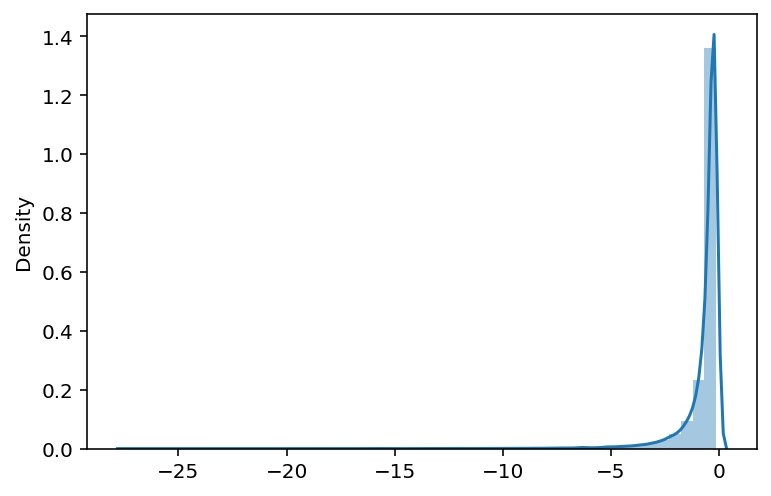

In [158]:
sns.distplot(model_loo.loo_i.values);

In [149]:
ppc_df["loo"] = model_loo.loo_i.values

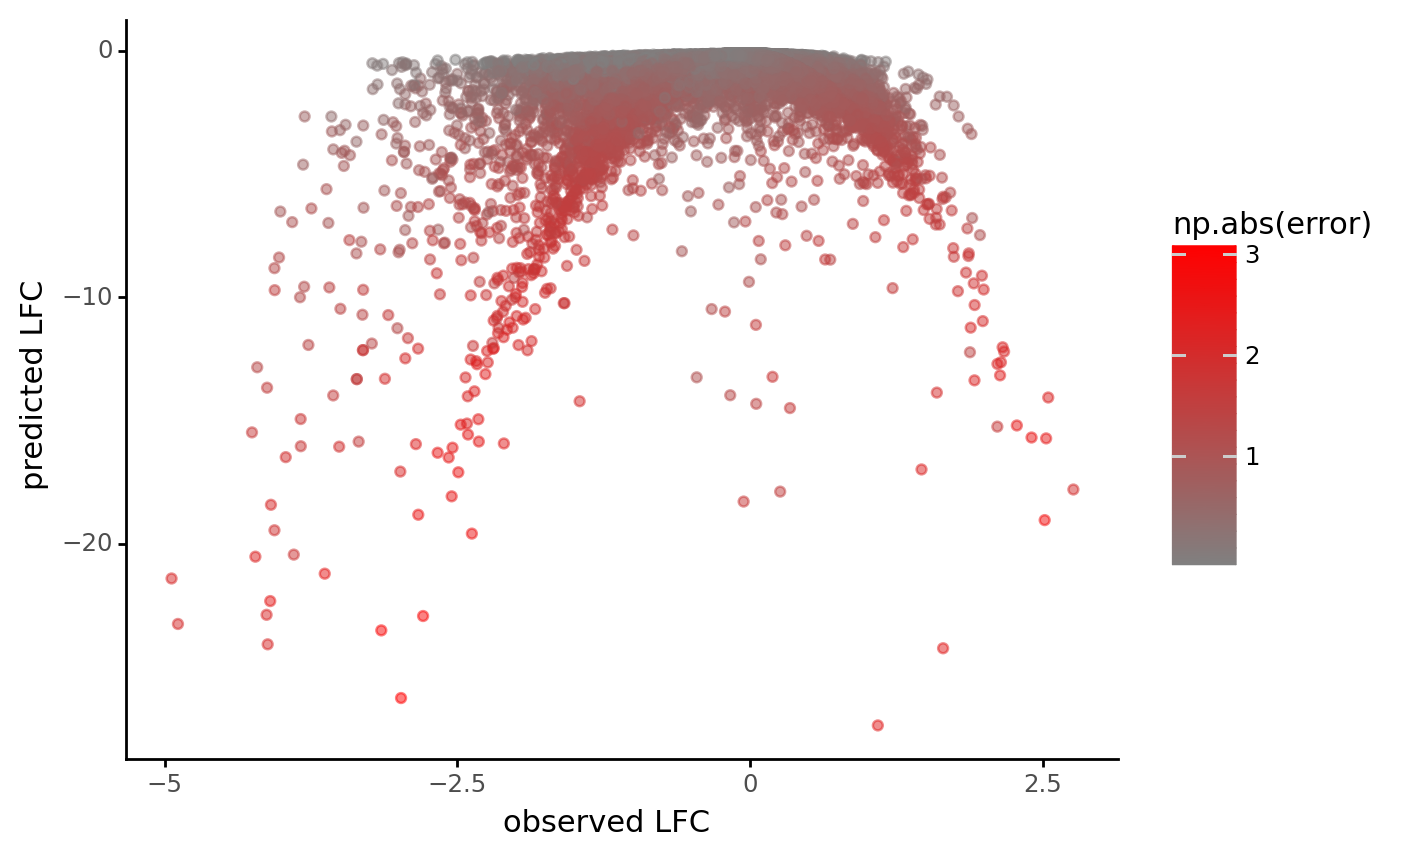

<ggplot: (358131291)>

In [150]:
(
    gg.ggplot(ppc_df, gg.aes(x="lfc", y="loo"))
    + gg.geom_point(gg.aes(color="np.abs(error)"), alpha=0.5)
    + gg.scale_color_gradient(low="grey", high="red")
    + gg.theme()
    + gg.labs(x="observed LFC", y="LOO", color="abs(error)")
)

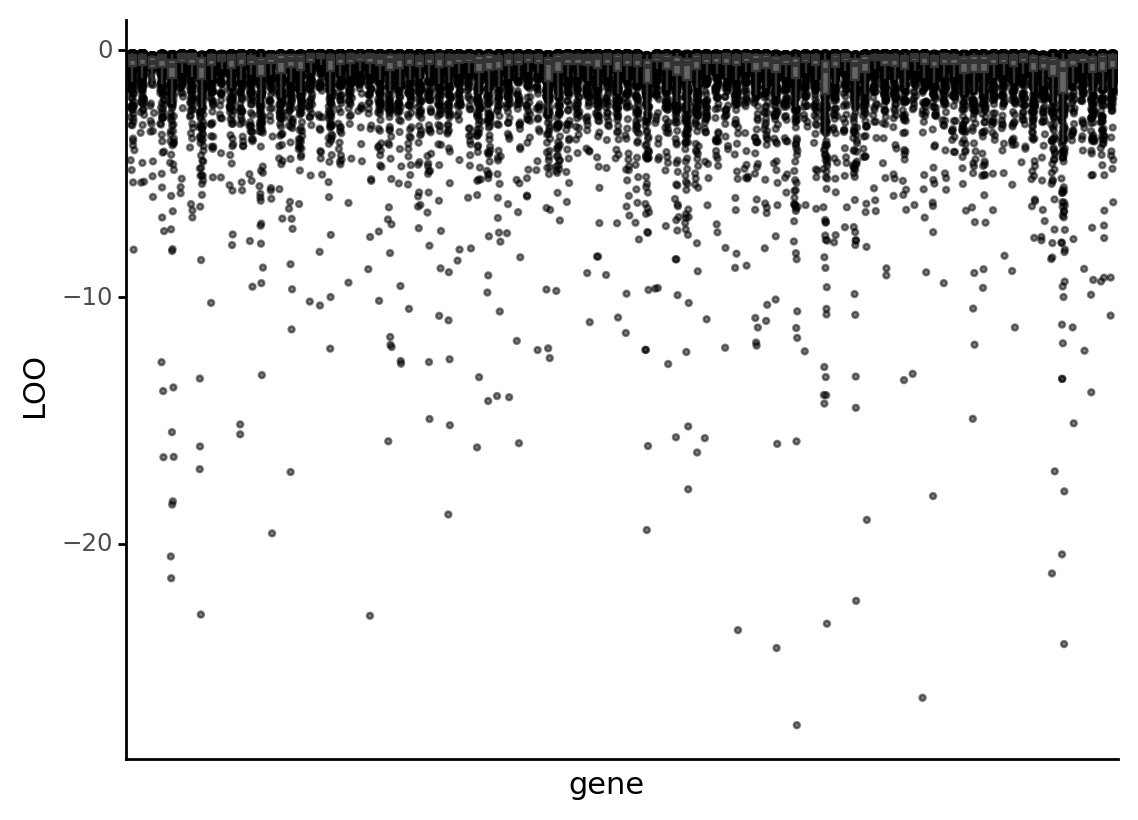

<ggplot: (369401805)>

In [156]:
(
    gg.ggplot(ppc_df, gg.aes(x="hugo_symbol", y="loo"))
    + gg.geom_jitter(width=0.2, alpha=0.5, size=0.7)
    + gg.geom_boxplot(outlier_alpha=0, alpha=0.4)
    + gg.theme(axis_text_x=gg.element_blank(), axis_ticks_major_x=gg.element_blank())
    + gg.labs(x="gene", y="LOO")
)

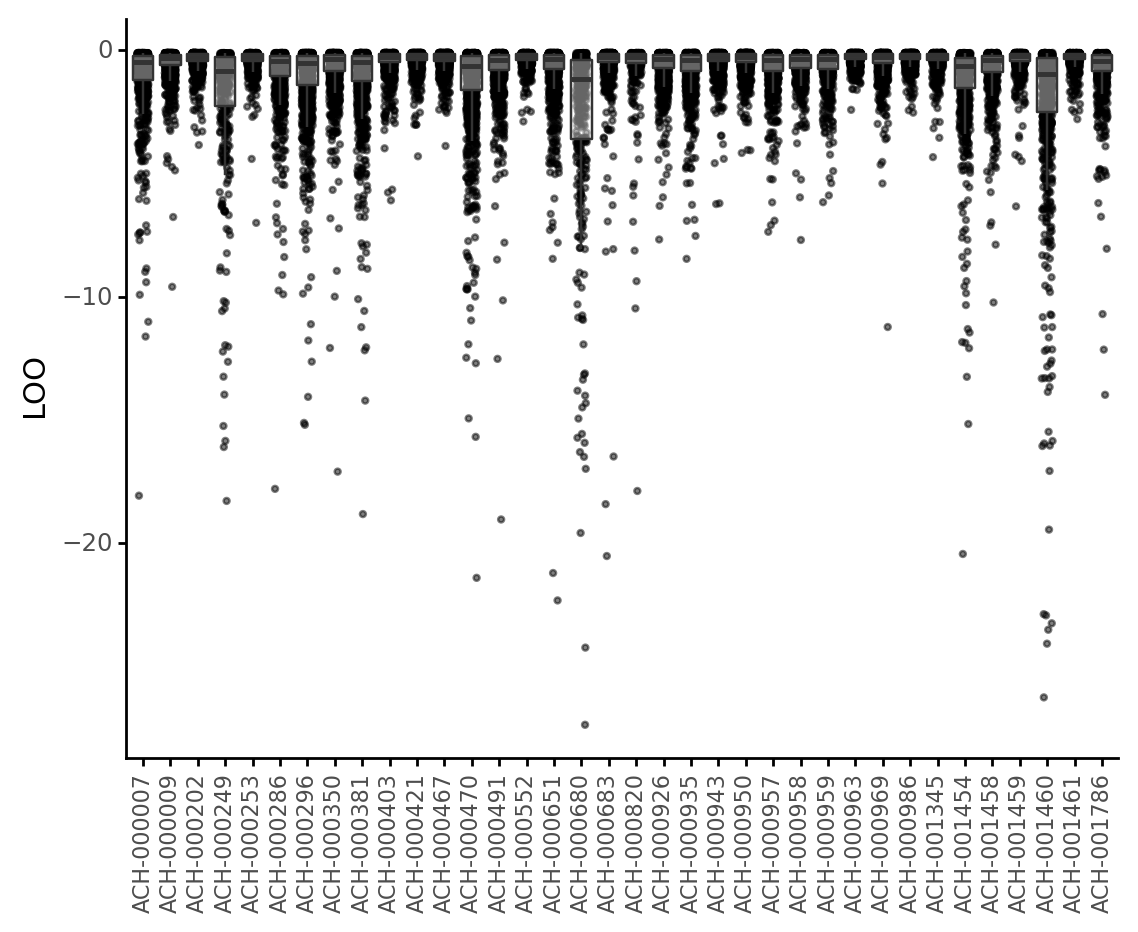

<ggplot: (358264179)>

In [152]:
(
    gg.ggplot(ppc_df, gg.aes(x="depmap_id", y="loo"))
    + gg.geom_jitter(width=0.2, alpha=0.5, size=0.7)
    + gg.geom_boxplot(outlier_alpha=0, alpha=0.4)
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, size=8),
    )
    + gg.labs(x=None, y="LOO")
)

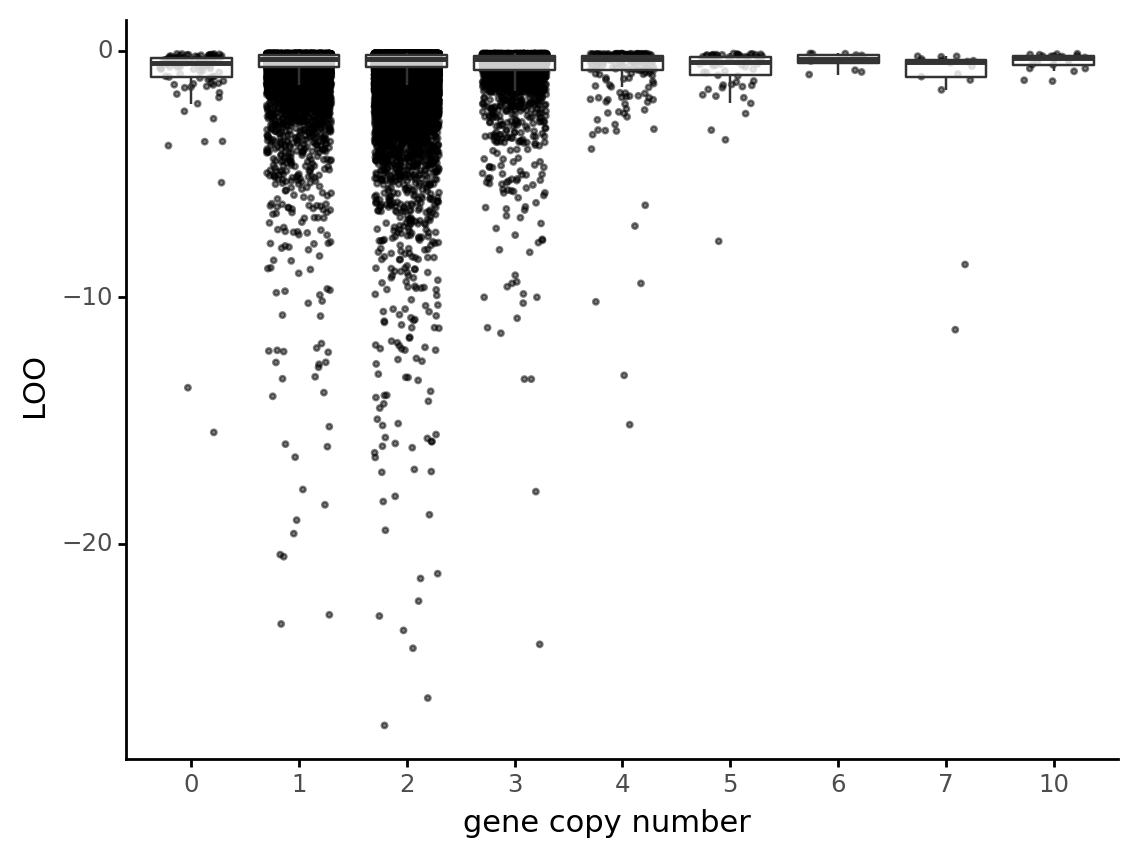

<ggplot: (368932452)>

In [171]:
# Remove samples without gene CN data.
ppc_df_no_missing = ppc_df.copy()[~ppc_df.gene_cn.isna()]
ppc_df_no_missing["binned_gene_cn"] = [
    np.min([round(x), 10]) for x in ppc_df_no_missing.gene_cn
]

(
    gg.ggplot(ppc_df_no_missing, gg.aes(x="factor(binned_gene_cn)", y="loo"))
    + gg.geom_jitter(size=0.6, alpha=0.5, width=0.3)
    + gg.geom_boxplot(outlier_alpha=0, alpha=0.8)
    + gg.labs(x="gene copy number (max 10)", y="LOO")
)

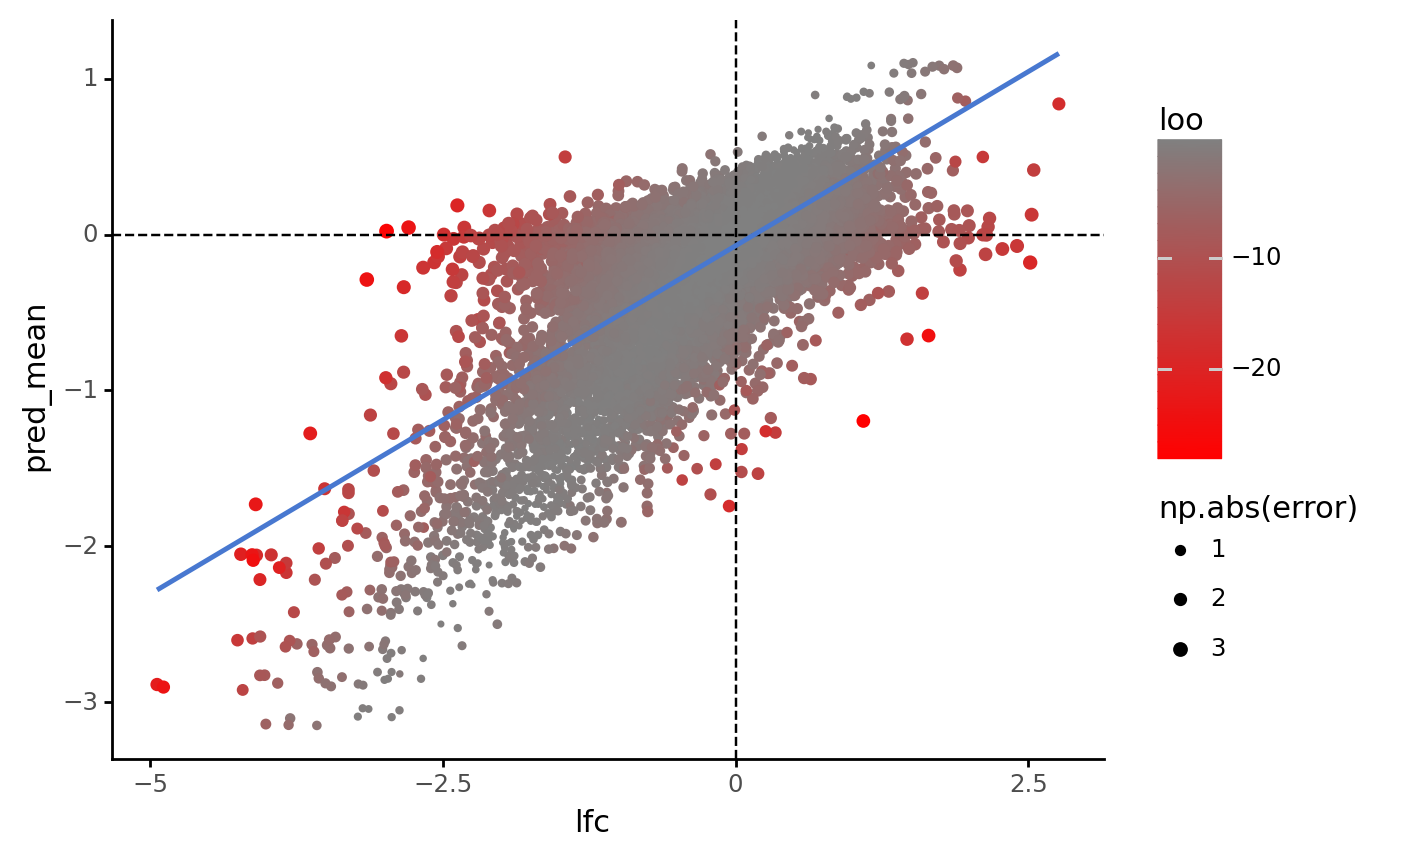

<ggplot: (361221726)>

In [154]:
(
    gg.ggplot(ppc_df, gg.aes(x="lfc", y="pred_mean"))
    + gg.geom_point(gg.aes(color="loo", size="np.abs(error)"))
    + gg.geom_hline(yintercept=0, linetype="--")
    + gg.geom_vline(xintercept=0, linetype="--")
    + gg.geom_smooth(se=False, alpha=0.75, color=SeabornColor.blue)
    + gg.scale_color_gradient(low="red", high="grey", alpha=0.5)
    + gg.scale_size_continuous(range=(0.3, 2))
)

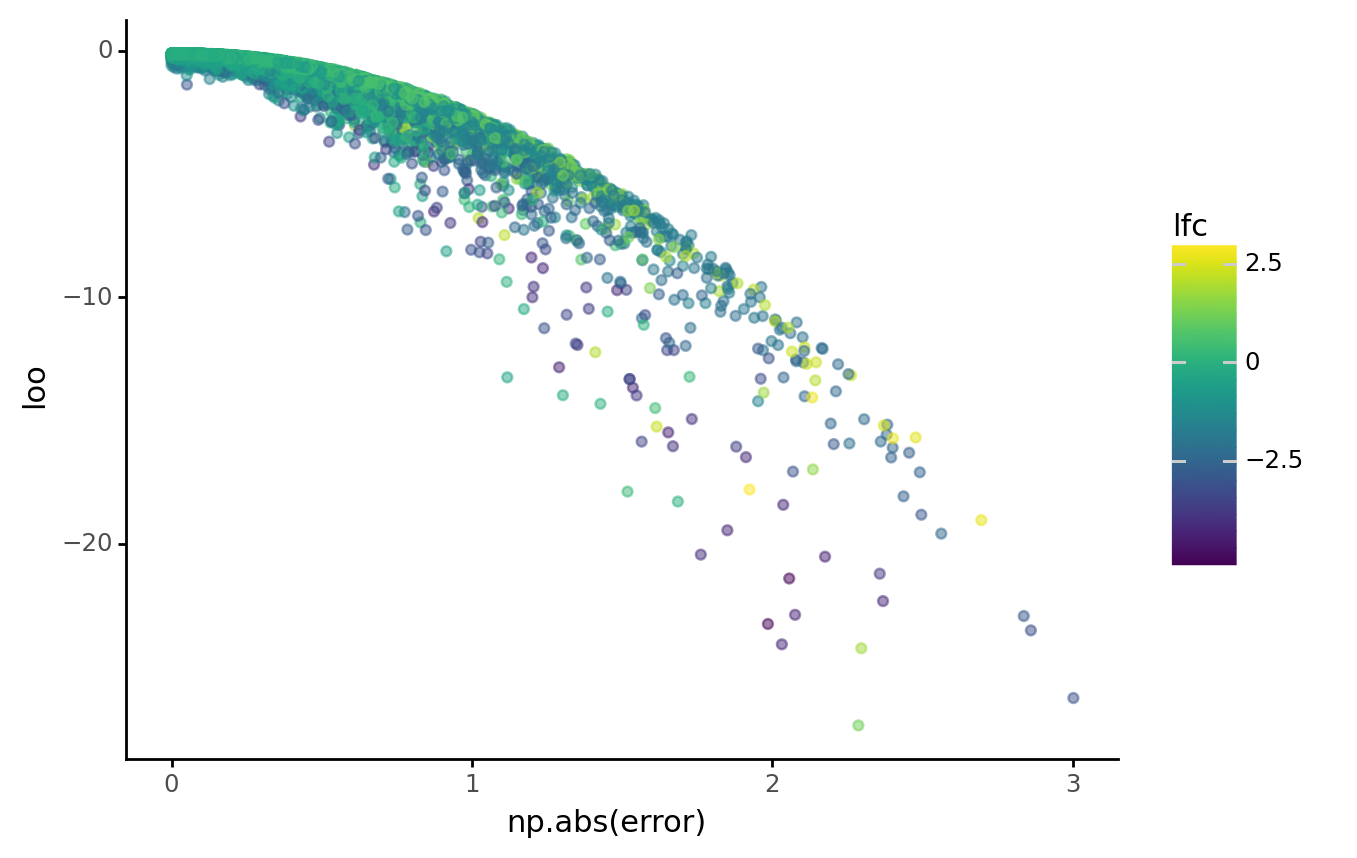

<ggplot: (363289890)>

In [155]:
(
    gg.ggplot(ppc_df, gg.aes(x="np.abs(error)", y="loo"))
    + gg.geom_point(gg.aes(color="lfc"), alpha=0.5)
)

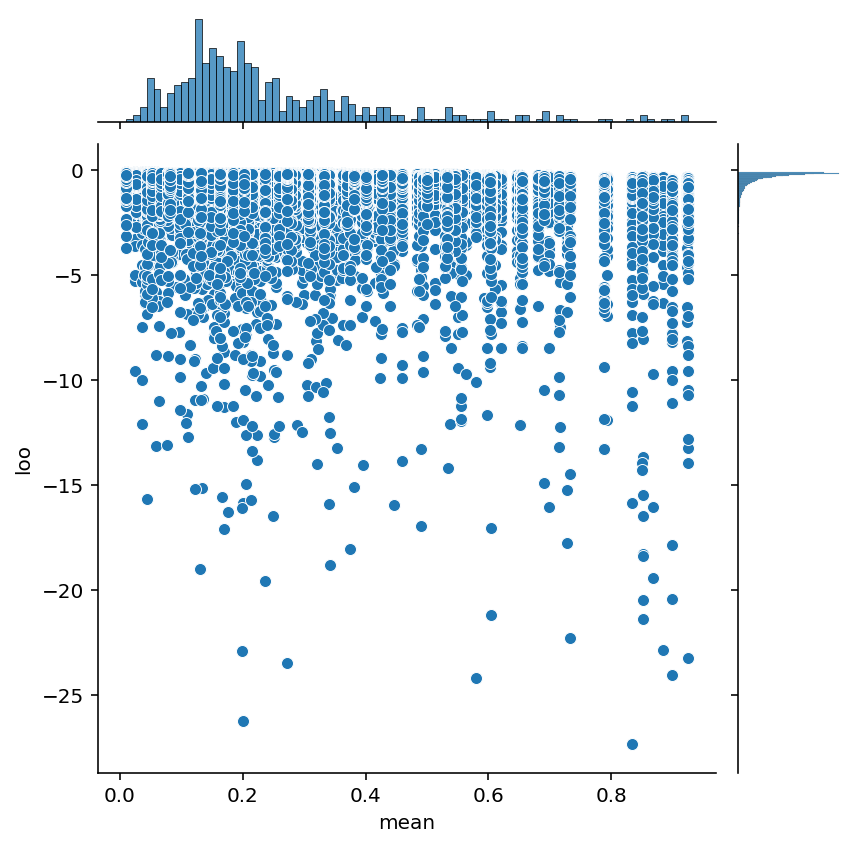

In [170]:
q_post = az.summary(az_model, var_names="q", kind="stats", hdi_prob=0.89)
q_post["sgrna"] = data.sgrna.cat.categories.values
q_post.head()

ppc_df_q = ppc_df.merge(q_post, on="sgrna")

sns.jointplot(x="mean", y="loo", data=ppc_df_q);

---

In [34]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 4.86 minutes


In [35]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-03-16

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

Compiler    : Clang 11.0.1 
OS          : Darwin
Release     : 20.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac

Git branch: crc-m2

pymc3     : 3.11.1
pandas    : 1.2.3
seaborn   : 0.11.1
matplotlib: 3.3.4
numpy     : 1.20.1
theano    : 1.0.5
re        : 2.2.1
arviz     : 0.11.2
plotnine  : 0.7.1

